# load data & library

In [165]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

In [166]:
train = pd.read_csv("house/train.csv", index_col="Id")
print(train.shape)
train.head(2)

(1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [167]:
test = pd.read_csv("house/test.csv", index_col="Id")
print(test.shape)
test.head(2)

(1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


In [168]:
set(train.columns) - set(test.columns)

{'SalePrice'}

# 전처리 한번에 하기 위해 concat
* 장점
    * 전처리를 한번만 해도 됨
* 단점
    * test에만 등장하는 데이터를 피처에 사용하면 안되는 대회 정책이 있을 때 위반이 될 수 있음
    * 현실에서는 불가능한 방법

In [169]:
df = pd.concat([train, test])
df.shape

(2919, 80)

# EDA

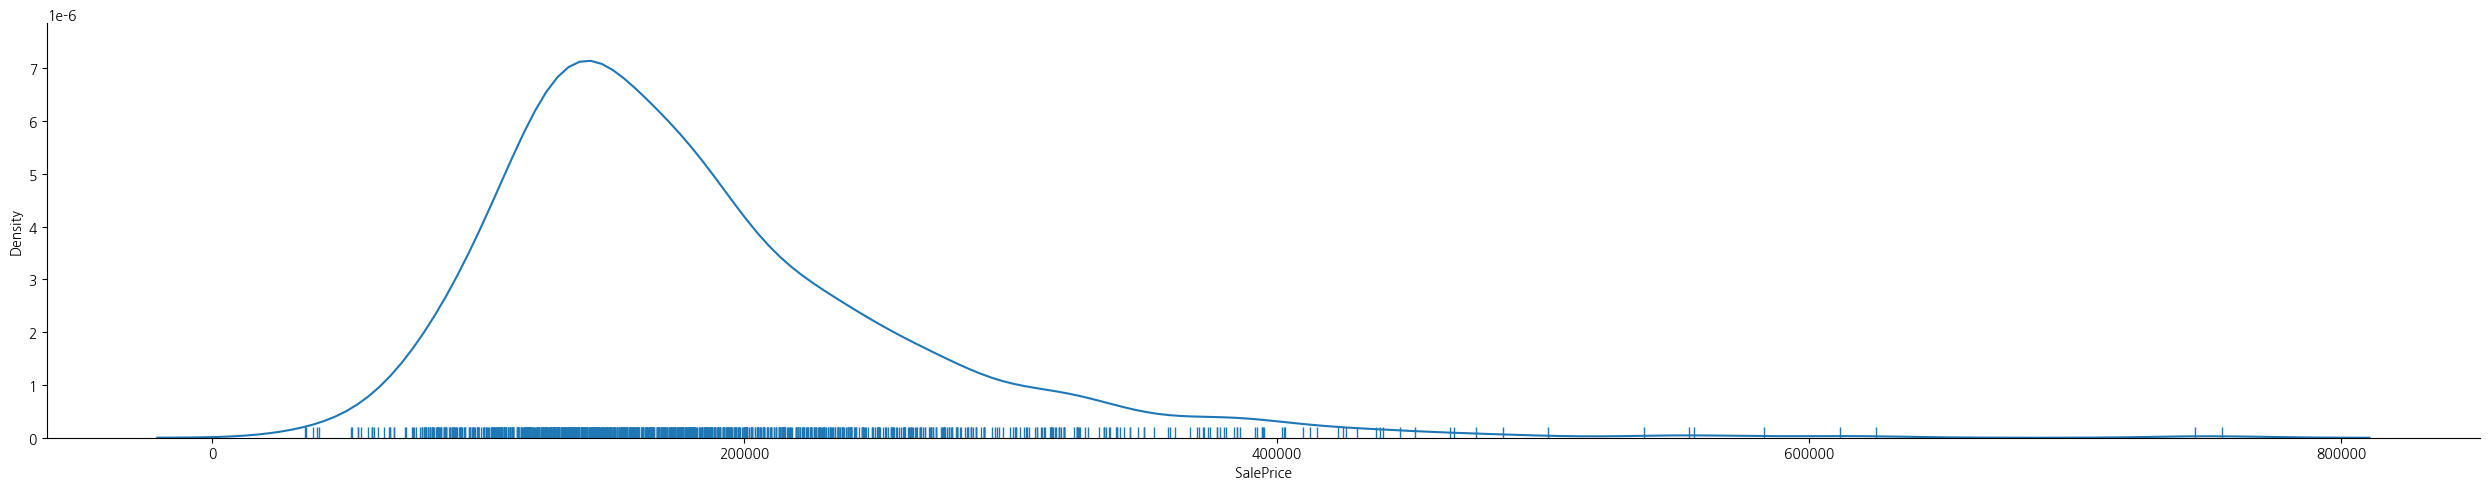

In [170]:
# aspect=너비, plotly의 width 와 같은 의미, 그래프의 너비, 가로 길이 의미
sns.displot(data=df, x="SalePrice", aspect=5, rug=True, kind="kde")
plt.show()

# 왜도 & 첨도

In [171]:
print("왜도(Skewness):", train["SalePrice"].skew())
print("첨도(Kurtosis):", train["SalePrice"].kurtosis())

왜도(Skewness): 1.8828757597682129
첨도(Kurtosis): 6.536281860064529


In [172]:
train["SalePrice_log1p"] = np.log1p(train["SalePrice"])

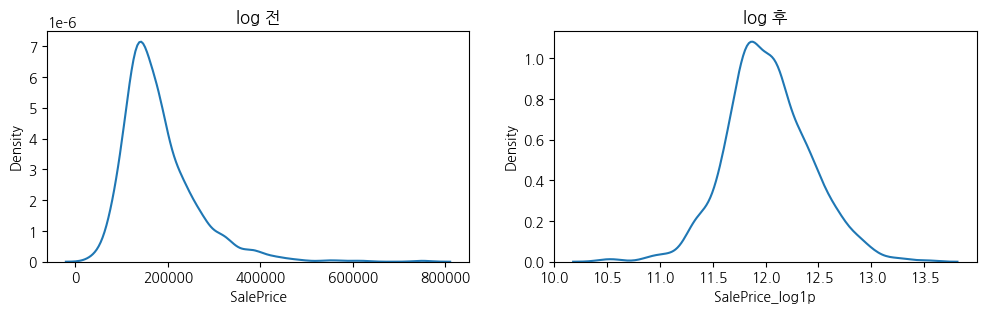

In [173]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
sns.kdeplot(train["SalePrice"], ax=ax[0]).set_title("log 전")
sns.kdeplot(train["SalePrice_log1p"], ax=ax[1]).set_title("log 후")
plt.show()

In [174]:
# 정규 분포로 변환 후 왜도 첨도
print("왜도(Skewness):", train["SalePrice_log1p"].skew())
print("첨도(Kurtosis):", train["SalePrice_log1p"].kurtosis())

왜도(Skewness): 0.12134661989685329
첨도(Kurtosis): 0.809519155707878


# 결측치

## 결측치 조회

In [175]:
isna_sum = df.isnull().sum()
isna_mean = df.isnull().mean()

pd.concat([isna_sum, isna_mean], axis=1).nlargest(10, 1)

,0,1
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
SalePrice,1459,0.499829
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471
GarageQual,159,0.054471


In [176]:
# 결측치 비율이 높은 것은 삭제
null_feature = isna_mean[isna_mean > 0.8].index
null_feature

Index(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

In [177]:
df = df.drop(null_feature, axis=1)
df.shape

(2919, 76)

In [179]:
set(test.columns) - set(df.columns)

{'Alley', 'Fence', 'MiscFeature', 'PoolQC'}

## 결측치 채우기


### 범주형 데이터

In [180]:
# Garage 관련 범주형 변수 -> None
Garage_None = ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]

print(df[Garage_None].isnull().sum())
print("-----결측치 처리-----")
df[Garage_None] = df[Garage_None].fillna("None")
df[Garage_None].isnull().sum()

GarageType      157
GarageFinish    159
GarageQual      159
GarageCond      159
dtype: int64
-----결측치 처리-----


GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
dtype: int64

In [181]:
# Basement 관련 범주형 변수 -> None
Basement_None = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath"]

print(df[Basement_None].isnull().sum())
print("-----결측치 처리-----")
df[Basement_None] = df[Basement_None].fillna("None")
df[Basement_None].isnull().sum()

BsmtFinSF1      1
BsmtFinSF2      1
BsmtUnfSF       1
TotalBsmtSF     1
BsmtFullBath    2
BsmtHalfBath    2
dtype: int64
-----결측치 처리-----


BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
BsmtFullBath    0
BsmtHalfBath    0
dtype: int64

### 수치형 데이터

In [182]:
# Garage 관련 수치형 변수 -> 0
Garage_0 = ["GarageYrBlt", "GarageArea", "GarageCars"]

print(df[Garage_0].isnull().sum())
print("-----결측치 처리-----")
df[Garage_0] = df[Garage_0].fillna(0)
df[Garage_0].isnull().sum()

GarageYrBlt    159
GarageArea       1
GarageCars       1
dtype: int64
-----결측치 처리-----


GarageYrBlt    0
GarageArea     0
GarageCars     0
dtype: int64

In [183]:
# Basement 관련 수치형 변수 -> 0
Basement_0 = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]

print(df[Basement_0].isnull().sum())
print("-----결측치 처리-----")
df[Basement_0] = df[Basement_0].fillna(0)
df[Basement_0].isnull().sum()

BsmtQual        81
BsmtCond        82
BsmtExposure    82
BsmtFinType1    79
BsmtFinType2    80
dtype: int64
-----결측치 처리-----


BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
dtype: int64

### 최빈값

In [184]:
fill_mode = ['MSZoning', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional']

In [185]:
df[fill_mode].isnull().sum()

MSZoning       4
KitchenQual    1
Exterior1st    1
Exterior2nd    1
SaleType       1
Functional     2
dtype: int64

In [186]:
for col in fill_mode:
    mode = df[col].mode()[0]
    df[col] = df[col].fillna(mode)

In [187]:
df[fill_mode].isnull().sum()

MSZoning       0
KitchenQual    0
Exterior1st    0
Exterior2nd    0
SaleType       0
Functional     0
dtype: int64

In [189]:
df[fill_mode[0]].value_counts()

RL         2269
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

# 상관계수

In [47]:
# label "SalePrice"와 상관계수
corr = df.corr()["SalePrice"]
corr

MSSubClass      -0.084284
LotFrontage      0.351799
LotArea          0.263843
OverallQual      0.790982
OverallCond     -0.077856
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.477493
BsmtFinSF1       0.386420
BsmtFinSF2      -0.011378
BsmtUnfSF        0.214479
TotalBsmtSF      0.613581
1stFlrSF         0.605852
2ndFlrSF         0.319334
LowQualFinSF    -0.025606
GrLivArea        0.708624
BsmtFullBath     0.227122
BsmtHalfBath    -0.016844
FullBath         0.560664
HalfBath         0.284108
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
TotRmsAbvGrd     0.533723
Fireplaces       0.466929
GarageYrBlt      0.486362
GarageCars       0.640409
GarageArea       0.623431
WoodDeckSF       0.324413
OpenPorchSF      0.315856
EnclosedPorch   -0.128578
3SsnPorch        0.044584
ScreenPorch      0.111447
PoolArea         0.092404
MiscVal         -0.021190
MoSold           0.046432
YrSold          -0.028923
SalePrice        1.000000
Name: SalePrice, dtype: float64

In [60]:
# 특정 수치 이상의 상관계수 조회
corr[abs(corr) > 0.6]

OverallQual    0.790982
TotalBsmtSF    0.613581
1stFlrSF       0.605852
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
SalePrice      1.000000
Name: SalePrice, dtype: float64

In [61]:
# 인덱스 확인
corr[abs(corr) > 0.6].index

Index(['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageCars',
       'GarageArea', 'SalePrice'],
      dtype='object')

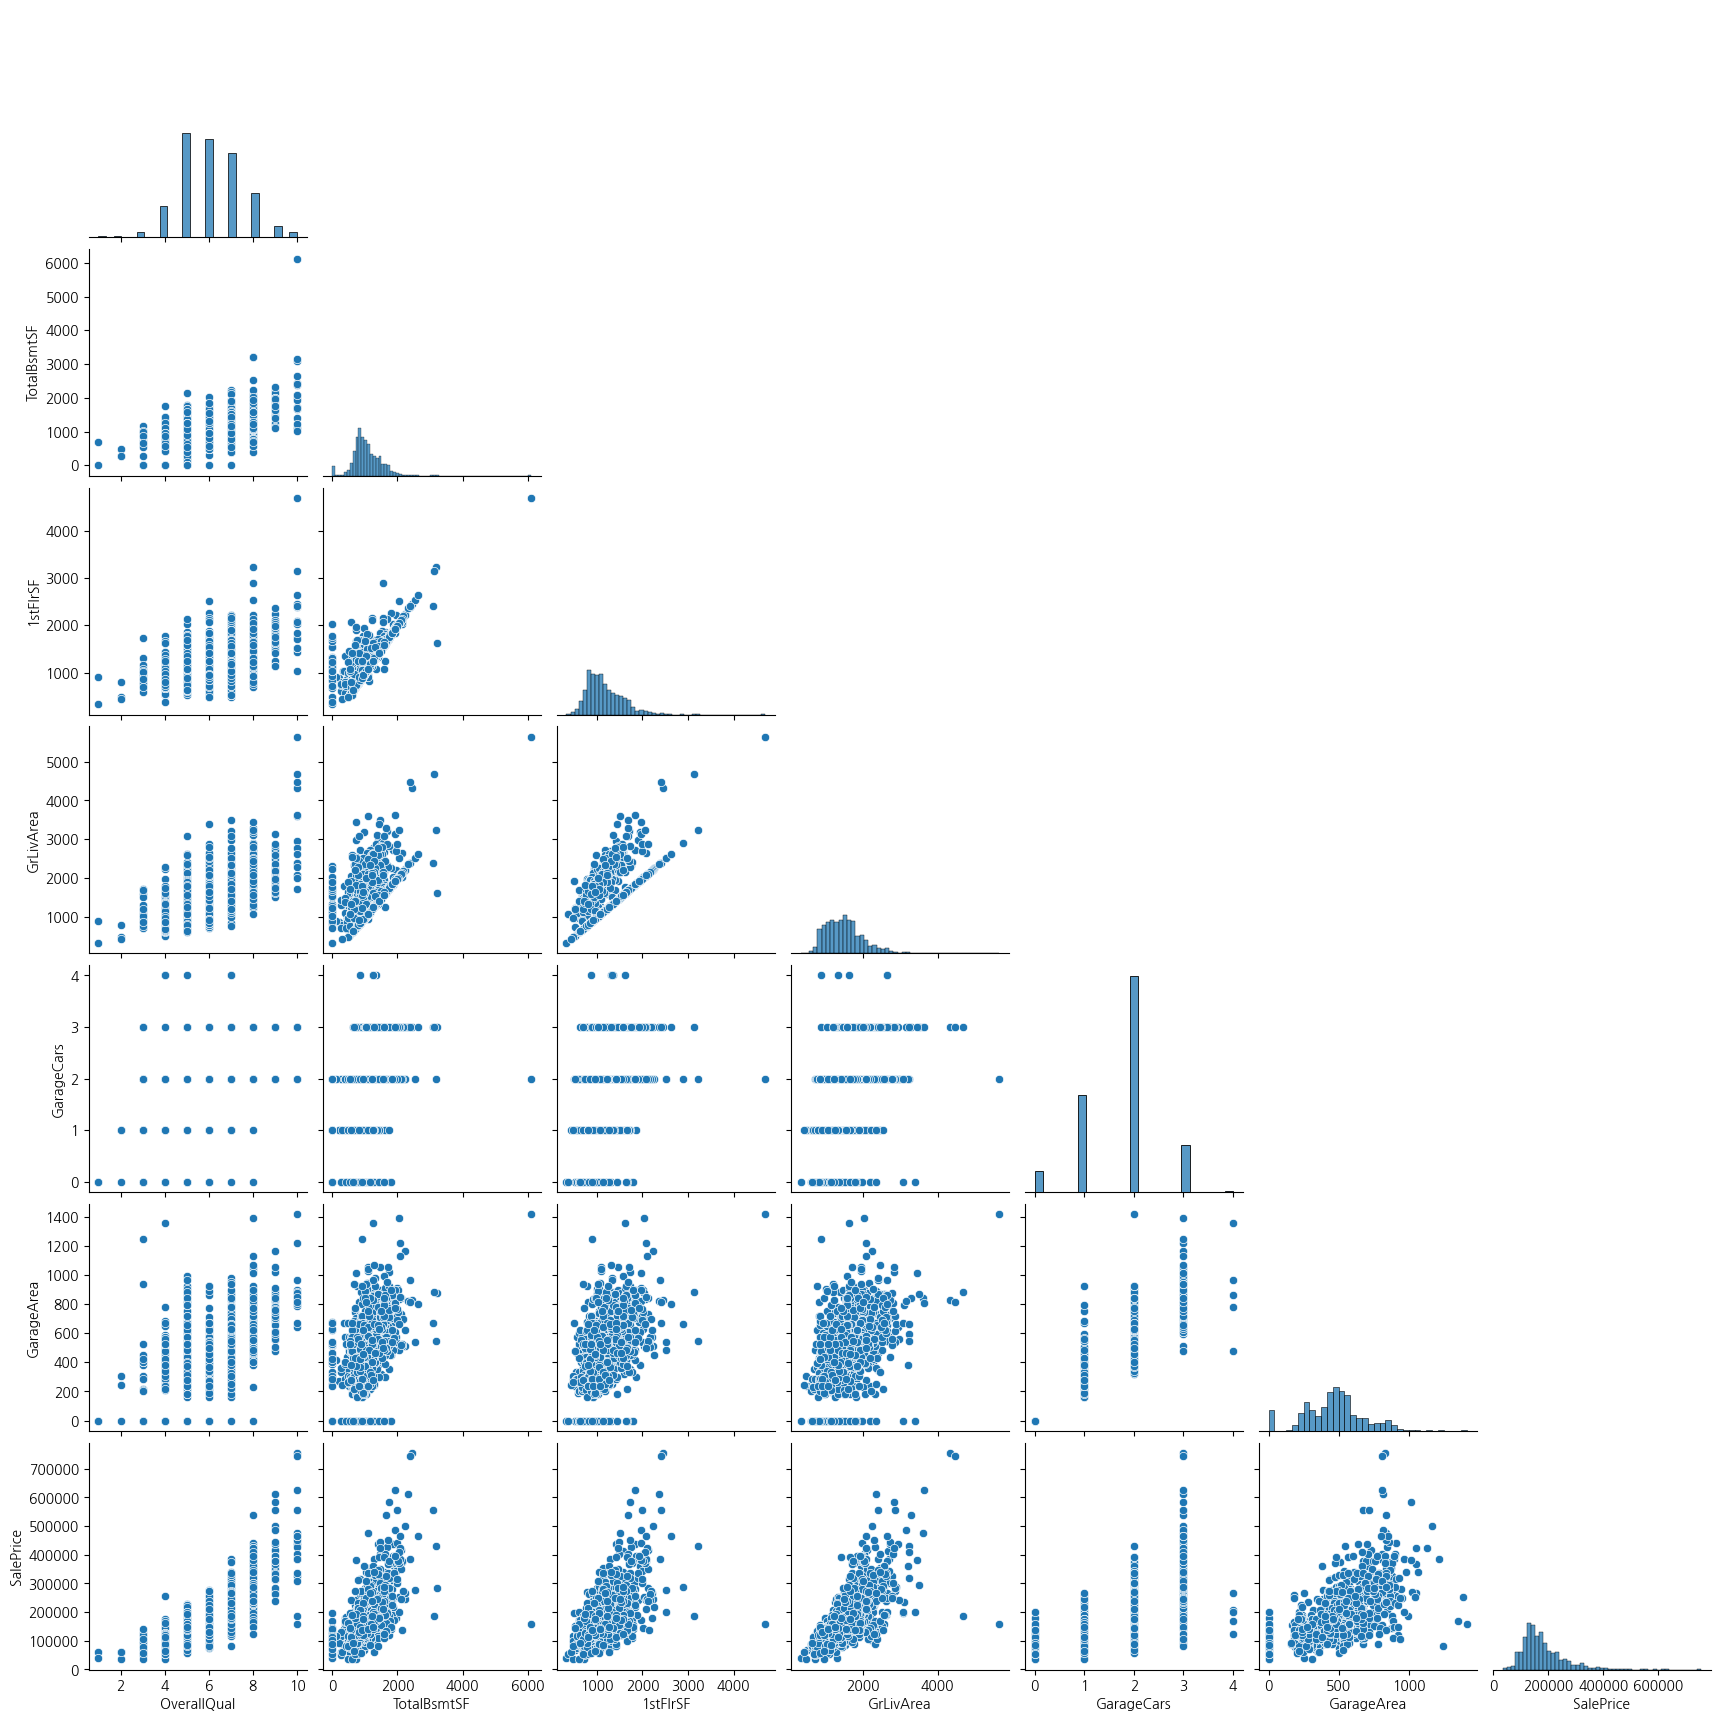

In [63]:
sns.pairplot(train[corr[abs(corr) > 0.6].index], corner=True)
plt.show()

# 파생변수

In [64]:
df["TotalSF"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]

# 데이터 타입 변경
* 수치형 데이터이지만 개수가 적다면 one-hot-encoding으로 범주화 가능

In [214]:
# 수치 데이터의 고유값 개수 확인
num_nunique = df.select_dtypes(exclude="O").nunique().sort_values()
num_nunique

HalfBath            3
KitchenAbvGr        4
Fireplaces          5
YrSold              5
FullBath            5
GarageCars          6
BedroomAbvGr        8
OverallCond         9
OverallQual        10
MoSold             12
PoolArea           14
TotRmsAbvGrd       14
MSSubClass         16
3SsnPorch          31
LowQualFinSF       36
MiscVal            38
YearRemodAdd       61
GarageYrBlt       104
YearBuilt         118
ScreenPorch       121
LotFrontage       128
EnclosedPorch     183
OpenPorchSF       252
WoodDeckSF        379
MasVnrArea        444
GarageArea        603
2ndFlrSF          635
SalePrice         663
1stFlrSF         1083
GrLivArea        1292
LotArea          1951
dtype: int64

In [218]:
# 20개 미만은 범주형으로 간주하여 조회
# 기준은 데이터마다 다름
num_nunique[num_nunique < 20]

HalfBath         3
KitchenAbvGr     4
Fireplaces       5
YrSold           5
FullBath         5
GarageCars       6
BedroomAbvGr     8
OverallCond      9
OverallQual     10
MoSold          12
PoolArea        14
TotRmsAbvGrd    14
MSSubClass      16
dtype: int64

In [219]:
num_to_str_col = ["MSSubClass", "OverallCond", "YrSold", "MoSold"]
df[num_to_str_col]

,MSSubClass,OverallCond,YrSold,MoSold
Id,,,,
1,60,5,2008,2
2,20,8,2007,5
3,60,5,2008,9
4,70,5,2006,2
5,60,5,2008,12
...,...,...,...,...
2915,160,7,2006,6
2916,160,5,2006,4
2917,20,7,2006,9


In [220]:
# 수치형의 데이터 col
df[num_to_str_col].dtypes

MSSubClass     int64
OverallCond    int64
YrSold         int64
MoSold         int64
dtype: object

In [221]:
# 범주형 데이터 col로 변경
df[num_to_str_col] = df[num_to_str_col].astype(str)
df[num_to_str_col].dtypes

MSSubClass     object
OverallCond    object
YrSold         object
MoSold         object
dtype: object

# 나머지 수치 변수

In [222]:
feature_num = df.select_dtypes(include="number").columns.tolist()

# label 제거
feature_num.remove("SalePrice")
feature_num

['LotFrontage',
 'LotArea',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

In [226]:
df[feature_num].isnull().sum().sum()

509

In [224]:
median = df[feature_num].median()
median

LotFrontage        68.0
LotArea          9453.0
OverallQual         6.0
YearBuilt        1973.0
YearRemodAdd     1993.0
MasVnrArea          0.0
1stFlrSF         1082.0
2ndFlrSF            0.0
LowQualFinSF        0.0
GrLivArea        1444.0
FullBath            2.0
HalfBath            0.0
BedroomAbvGr        3.0
KitchenAbvGr        1.0
TotRmsAbvGrd        6.0
Fireplaces          1.0
GarageYrBlt      1977.0
GarageCars          2.0
GarageArea        480.0
WoodDeckSF          0.0
OpenPorchSF        26.0
EnclosedPorch       0.0
3SsnPorch           0.0
ScreenPorch         0.0
PoolArea            0.0
MiscVal             0.0
dtype: float64

In [227]:
df[feature_num] = df[feature_num].fillna(median)

In [228]:
df[feature_num].isnull().sum().sum()

0

# 로그 변환

## label

In [230]:
# label의 왜도, 첨도
train["SalePrice"].skew(), train["SalePrice"].kurt()

(1.8828757597682129, 6.536281860064529)

In [231]:
# 로그 변환 후 label 왜도, 첨도
# predict 이후 expm1 처리 필요
train["SalePrice_log1p"].skew(), train["SalePrice_log1p"].kurt()

(0.12134661989685329, 0.809519155707878)

## feature

In [234]:
feature_skew = abs(df.skew()).sort_values() 
feature_skew

/var/folders/ql/gbsdt1191mbf_hk8mhnwwpd80000gn/T/ipykernel_35731/2026087809.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feature_skew = abs(df.skew()).sort_values()


YrSold            0.132467
FullBath          0.167692
MoSold            0.195985
OverallQual       0.197212
GarageCars        0.219694
GarageArea        0.239380
BedroomAbvGr      0.326492
YearRemodAdd      0.451252
OverallCond       0.570605
YearBuilt         0.600114
HalfBath          0.694924
Fireplaces        0.733872
TotRmsAbvGrd      0.758757
2ndFlrSF          0.862118
GrLivArea         1.270010
MSSubClass        1.376165
1stFlrSF          1.470360
LotFrontage       1.675713
WoodDeckSF        1.843380
SalePrice         1.882876
OpenPorchSF       2.536417
MasVnrArea        2.614936
GarageYrBlt       3.908213
ScreenPorch       3.948723
EnclosedPorch     4.005950
KitchenAbvGr      4.304467
3SsnPorch        11.381914
LowQualFinSF     12.094977
LotArea          12.829025
PoolArea         16.907017
MiscVal          21.958480
dtype: float64

In [236]:
# 한쪽으로 쏠린 데이터 col
skewed_col = feature_skew[feature_skew > 2].index
skewed_col

Index(['OpenPorchSF', 'MasVnrArea', 'GarageYrBlt', 'ScreenPorch',
       'EnclosedPorch', 'KitchenAbvGr', '3SsnPorch', 'LowQualFinSF', 'LotArea',
       'PoolArea', 'MiscVal'],
      dtype='object')